# Reconocimiento de acciones humanas
Daniel Alejandro Alonso Bastos

Comparación de arquitecturas RNN y CNN para reconocimiento de acciones humanas en el conjunto [UCF11](https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7). La solución debe de cumplir con los siguientes puntos:

* Usar las características convolucionales vistas en clase.
* Implementar una arquitectura RNN bidireccional con una capa GRU.
* Implementar una arquitectura CNN con una capa Conv1d.
* Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

## 1 Preparación

1.1 Bibliotecas

In [ ]:
# inspeccionar arquitecturas
!pip install torchinfo
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 40.4 MB/s 
     |████████████████████████████████| 6.6 MB 53.6 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=5fcb8ef79e6228fad1e4a1158d24b28663b11c0ff0399f03e89d6c81b423196a
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b980b8535e72a0
Successfully built asciitree


In [ ]:
# sistema de archivos
import os
# funciones aleatorias
import random
# descomprimir
import tarfile
# sistema de archivos
from os.path import join

# arreglos multidimensionales
import numpy as np
import matplotlib.pyplot as plt

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
# almacenamiento de arreglos multidimensionales
import zarr
#redes
from torch.utils.data import DataLoader, random_split
# barras de progreso
from tqdm.auto import tqdm
from tqdm.auto import trange
# inspección de arquitectura
from torchinfo import summary

# directorio de datos
DATA_DIR = '../data'
# tamaño del lote
BATCH_SIZE = 32
# tamaño del vector de características
FEAT_SIZE = 1024

# parametros para graficas
MARKER = 'o'
MARKER_SIZE = 4

### 1.2 Auxiliares

In [ ]:
# reproducibilidad
def set_seed(seed=0):
  """Initializes pseudo-random number generators."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

set_seed()

# grafica de perdida y accuracy del modelo
def plot_loss_accuracy(loss_hist, accuracy_hist):
  train_loss, test_loss = zip(*loss_hist)
  train_acc, test_acc = zip(*accuracy_hist)

  fig,ax = plt.subplots(1,2,figsize=(16,5))

  ax[0].plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Model loss')
  ax[0].grid()
  ax[0].legend()

  ax[1].plot(train_acc,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  ax[1].plot(test_acc,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy (%)')
  ax[1].set_title('Model accuracy')
  ax[1].set_ylim([0,100])
  ax[1].grid()
  ax[1].legend()

  plt.show()

## 2 Datos

### 2.1 Conjunto de datos

In [ ]:
class UCF11:

    def __init__(self, root, download=False):
        self.root = root
        self.zarr_dir = join(root, 'ucf11.zarr')
        if download:
            self.download()
        self.z = zarr.open(self.zarr_dir, 'r')
        self.paths = list(self.z.array_keys())
        
    def __getitem__(self, i):
        arr = self.z[self.paths[i]]
        x = np.array(arr)
        y = np.array(arr.attrs['y'], dtype=np.int64)
        return x, y

    def __len__(self):
        return len(self.paths)
    
    def _check_integrity(self):
        return os.path.isdir(self.zarr_dir)
    
    def _extract(self, root, filename):
        tar = tarfile.open(join(root, filename), "r:gz")
        tar.extractall(root)
        tar.close()

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        tvu.download_url(
            url='https://cloud.xibalba.com.mx/s/apYrNA4iM4K65o7/download',
            root=self.root,
            filename='ucf11.zarr.tar.gz',
            md5='c8a82454f9ec092d00bcd99c849e03fd'
        )
        self._extract(self.root, 'ucf11.zarr.tar.gz')

A continuación se genera una instancia de UCF11 y se descarga el conjunto de datos que tiene las características convolucionales obtenidas del notebook [3b_ucf11_feats.ipynb](https://github.com/gibranfp/CursoAprendizajeProfundo/blob/2023-1/notebooks/3b_ucf11_feats.ipynb).

In [ ]:
ds = UCF11(join(DATA_DIR, 'ucf11'), True)
x, y = ds[0]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'x [0][:5]={x[0][:5]}')
print(f'y shape={y.shape} dtype={y.dtype} {y}')
print(f'y {y}')

  0%|          | 0/53436566 [00:00<?, ?it/s]

x shape=(10, 1024) dtype=float32
x [0][:5]=[0.00022111 0.00368518 0.00314753 0.00201778 0.09296297]
y shape=() dtype=int64 0
y 0


Se realiza la partición del conjunto de entrenamiento y prueba

In [ ]:
trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

(1279, 320)

### 2.2 Cargadores de datos

In [ ]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # procesos paralelos
    num_workers=2
)

El tensor $x$ consiste en: [lote, secuancia, vector de características]

In [ ]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 10, 1024]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


## 3 Modelos

### 3.1 Arquitectura RNN bidireccional con una capa GRU

In [ ]:
class RNN(nn.Module):
  def __init__(self,bidirectional=False, input_size = 1024, 
               hidden_size=128, num_classes=11):
    super().__init__()
    
    # si RNN es bidireccional, entonces se tiene el doble de estados a la salida
    num_directions = 2 if bidirectional else 1

    self.bn = nn.BatchNorm1d(input_size)
    self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                      num_layers=1, batch_first=True, 
                      bidirectional=bidirectional)
    self.cls = nn.Linear(num_directions*hidden_size, num_classes)

  def forward(self, x):
    # el vector de caracteristicas convolucionales es [B,S,F]
    # B -> batch, S -> seq, F -> features
    # [B,S,F] => [B,F,S]
    x = x.movedim(1, 2)
    x = self.bn(x) # [B,F,S]
    # [B,F,S] => [B,S,F]
    x = x.movedim(1, 2)
    # [B,S,F] => [B,S,H]
    # si es bidireccional -> [B,S,F] => [B,S,2*H]
    x, _ = self.rnn(x)
    # [B, S, H] => [B, H]
    #x = x[:, -1, :]
    x = torch.mean(x,1)
    # [B, H] = [B, 11]
    x = self.cls(x)
    return x

Instancia y prueba de la arquitectura

In [ ]:
model_RNNBid = RNN(bidirectional=True)
model_RNNBid(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 1, 11])

In [ ]:
model_RNN = RNN()

### 3.2 Arquitectura CNN con una capa Conv1d

El tamaño de salida de la convolución 1D se calcula con la siguiente [ecuación](https://stackoverflow.com/questions/62162576/calculating-shape-of-conv1d-layer-in-pytorch):


\begin{equation}
L_{out} = \left \lfloor \frac{L_{in}+2\times padding - dilation \times \left ( kernel_{size}-1 \right )-1}{stride}+1 \right \rfloor
\end{equation}



In [ ]:
class CNN(nn.Module):
  def __init__(self, input_size = 1024, in_channels = 10, out_channels = 10, 
               kernel_size = 3, num_classes=11):
    super().__init__()

    input_size_cls_cnn = self._calculate_output_conv1d(input_size, kernel_size)
    
    self.bn = nn.BatchNorm1d(input_size)
    self.cnn = nn.Conv1d(in_channels,out_channels,kernel_size)
    self.cls = nn.Linear(input_size_cls_cnn, num_classes)

  def _calculate_output_conv1d(self, in_size, kernel_size, stride=1, padding=0, dilation=1):
    return (in_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

  def forward(self, x):
    # el vector de caracteristicas convolucionales es [B,S,F]
    # B -> batch, S -> seq, F -> features
    # [B,S,F] => [B,F,S]
    x = x.movedim(1, 2)
    x = self.bn(x) # [B,F,S]
    # [B,F,S] => [B,S,F]
    x = x.movedim(1, 2)
    # [B,S,F] => [B,S,H]
    # si es bidireccional -> [B,S,F] => [B,S,2*H]
    x = self.cnn(x)
    # [B, S, H] => [B, H]
    #x = x[:, -1, :]
    x = torch.mean(x,1)
    # [B, H] = [B, 11]
    x = self.cls(x)
    return x

Instancia y prueba de la arquitectura

In [ ]:
model_CNN = CNN()
model_CNN(torch.zeros(1, 10, 1024)).shape

torch.Size([1, 11])

### 3.3 Modificar el tamaño de las capas para que ambos modelos tengan un número similar de parámetros

In [ ]:
model_CNN_M = CNN(out_channels=650)
summary(model_CNN_M, (1,10,1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─Conv1d: 1-2                            [1, 650, 1022]            20,150
├─Linear: 1-3                            [1, 11]                   11,253
Total params: 33,451
Trainable params: 33,451
Non-trainable params: 0
Total mult-adds (M): 20.61
Input size (MB): 0.04
Forward/backward pass size (MB): 5.40
Params size (MB): 0.13
Estimated Total Size (MB): 5.57

In [ ]:
model_RNNBid_M = RNN(bidirectional=True, hidden_size=5)
summary(model_RNNBid_M, (1,10,1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 10]               30,930
├─Linear: 1-3                            [1, 11]                   121
Total params: 33,099
Trainable params: 33,099
Non-trainable params: 0
Total mult-adds (M): 0.31
Input size (MB): 0.04
Forward/backward pass size (MB): 0.08
Params size (MB): 0.13
Estimated Total Size (MB): 0.26

## 4 Entrenamiento

In [ ]:
! nvidia-smi

Thu Nov 10 00:53:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     8W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# obtenemos dispositivo en gpu, si no en cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 4.1 Ciclo de entrenamiento

In [ ]:
def train_epoch(data_loader,model,opt,epoch):
  # loop sobre cada lote en el conjunto de entrenamiento
  for x, y_true in data_loader:
  #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Train'):
    # mover a dispositivo
    x = x.to(device)
    y_true = y_true.to(device)
    # se realiza inferencia
    y_lgts = model(x)
    # se calcula la perdida
    loss = F.cross_entropy(y_lgts, y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model, epoch):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses, accs = [], []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in data_loader:
    #for x, y_true in tqdm(data_loader, desc=f'E{epoch:2d} Test'):
      # mover a dispositivo
      x = x.to(device)
      y_true = y_true.to(device)
      y_lgts = model(x) # calculamos logits
      # calculo de las probabilidades
      y_prob = F.softmax(y_lgts, 1)
      # obtencion de la clase predicha
      y_pred = torch.argmax(y_prob, 1)
      # calculo de metricas
      loss_b = F.cross_entropy(y_lgts, y_true) # calculo de la perdida
      acc_b = (y_true == y_pred).type(torch.float32).mean() # calculo de la exactitud
      # guardar historial de las metricas
      losses.append(loss_b.item()*100)
      accs.append(acc_b.item()*100)
    
    # se obtiene el promedio de las metricas
    loss = np.mean(losses)
    acc = np.mean(accs)
    return loss, acc

def train(model, train_dl, test_dl,epochs=10,lr=1e-3,opt='Adam',
          L2lambda=0, seed=True, progress=True):
  #if seed: set_seed() # fijar semilla para reproducibilidad
  set_seed()
  # mover modelo a cpu/gpu
  model = model.to(device)
  # historiales
  loss_hist, acc_hist = [], []

  # optimizadores
  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=L2lambda)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr, weight_decay=L2lambda)
  if opt == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=L2lambda)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)

  # colocar el modelo en modo de evaluacion
  model.eval()

  # ciclo de entrenamiento
  for epoch in range_progress:
    # colocar al modelo en modo de entrenamiento
    model.train()
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer,epoch)
    # modelo en modo evaluacion
    model.eval()
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss, train_acc = eval_epoch(train_dl, model, epoch)
    test_loss, test_acc = eval_epoch(test_dl, model, epoch)
    # actualizar historial
    loss_hist.append([train_loss,test_loss])
    acc_hist.append([train_acc, test_acc])

    # impresion del progreso
    if progress:
      print(f'E{epoch:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] '
            f'acc=[{train_acc:6.2f},{test_acc:6.2f}] ')
      
  return loss_hist, acc_hist

### 4.2 Entrenamiento de la arquitectura RNN bidireccional

In [ ]:
loss_rnnbid, acc_rnnbid = train(model_RNNBid, trn_dl, tst_dl,epochs=10,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[184.12,197.59] acc=[ 44.96, 38.12] 
E01 loss=[135.56,177.61] acc=[ 64.50, 41.88] 
E02 loss=[ 97.02,164.35] acc=[ 77.87, 46.56] 
E03 loss=[ 69.51,156.17] acc=[ 84.99, 49.06] 
E04 loss=[ 51.94,159.00] acc=[ 89.52, 48.75] 
E05 loss=[ 39.40,154.93] acc=[ 91.86, 50.94] 
E06 loss=[ 31.56,157.73] acc=[ 92.80, 50.31] 
E07 loss=[ 25.57,156.26] acc=[ 94.14, 49.38] 
E08 loss=[ 23.50,154.66] acc=[ 93.98, 52.81] 
E09 loss=[ 20.78,157.26] acc=[ 93.51, 50.62] 


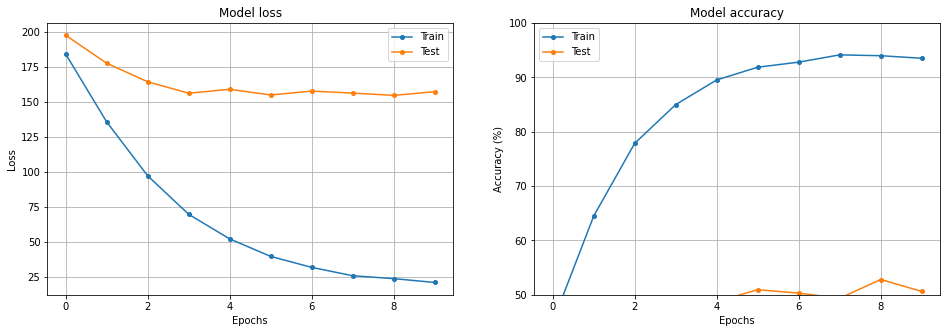

In [ ]:
plot_loss_accuracy(loss_rnnbid, acc_rnnbid)

### 4.3 Entrenamiento de la arquitectura CNN

In [ ]:
loss_cnn, acc_cnn = train(model_CNN, trn_dl, tst_dl,epochs=10,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[238.37,240.23] acc=[ 12.50,  9.69] 
E01 loss=[234.56,237.90] acc=[ 16.26, 12.19] 
E02 loss=[228.87,233.65] acc=[ 20.88, 14.69] 
E03 loss=[223.14,229.13] acc=[ 22.74, 18.12] 
E04 loss=[217.04,224.40] acc=[ 26.27, 22.81] 
E05 loss=[211.10,220.07] acc=[ 28.22, 23.12] 
E06 loss=[205.69,216.02] acc=[ 30.89, 24.06] 
E07 loss=[199.95,211.97] acc=[ 32.28, 25.62] 
E08 loss=[194.33,207.76] acc=[ 34.57, 27.50] 
E09 loss=[189.47,204.73] acc=[ 38.15, 30.31] 


In [ ]:
loss_cnn, acc_cnn = train(model_CNN, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[161.39,184.31] acc=[ 48.40, 36.56] 
E01 loss=[140.71,176.81] acc=[ 55.21, 42.19] 
E02 loss=[123.46,170.22] acc=[ 62.31, 44.06] 
E03 loss=[111.35,168.27] acc=[ 64.97, 45.62] 
E04 loss=[100.12,170.26] acc=[ 71.86, 45.94] 
E05 loss=[ 89.86,169.58] acc=[ 73.16, 50.31] 
E06 loss=[ 86.21,172.78] acc=[ 76.23, 50.00] 
E07 loss=[ 78.90,176.69] acc=[ 79.52, 49.06] 
E08 loss=[ 74.34,178.50] acc=[ 78.89, 48.75] 
E09 loss=[ 67.29,181.10] acc=[ 81.39, 47.19] 


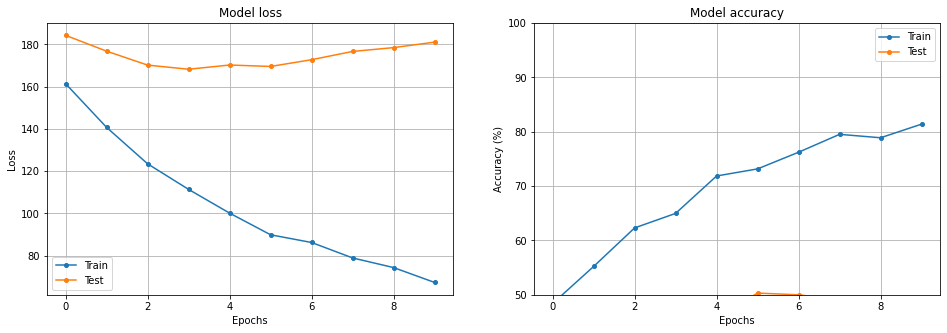

In [ ]:
plot_loss_accuracy(loss_cnn, acc_cnn)

### 4.3 Entrenamiento con las arquitecturas modificadas

In [ ]:
loss_rnnbid_M, acc_rnnbid_M = train(model_RNNBid_M, trn_dl, tst_dl,epochs=10,lr=1e-4,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[252.78,253.40] acc=[  8.75,  6.88] 
E01 loss=[249.90,252.25] acc=[  7.04,  5.94] 
E02 loss=[246.87,249.57] acc=[  8.21,  7.50] 
E03 loss=[245.41,248.57] acc=[  8.45,  7.81] 
E04 loss=[244.45,247.57] acc=[  8.60,  9.06] 
E05 loss=[243.12,247.14] acc=[  9.00,  9.06] 
E06 loss=[242.06,246.44] acc=[  9.16,  8.12] 
E07 loss=[241.19,245.97] acc=[  9.23,  9.69] 
E08 loss=[240.30,245.48] acc=[  9.15, 10.00] 
E09 loss=[239.64,244.81] acc=[  9.30,  9.38] 


In [ ]:
loss_rnnbid_M, acc_rnnbid_M = train(model_RNNBid_M, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[232.53,239.43] acc=[ 15.47, 13.75] 
E01 loss=[226.96,236.32] acc=[ 19.54, 15.94] 
E02 loss=[222.80,233.71] acc=[ 21.88, 17.50] 
E03 loss=[218.21,231.61] acc=[ 24.00, 19.06] 
E04 loss=[214.04,229.61] acc=[ 25.56, 20.94] 
E05 loss=[210.25,227.88] acc=[ 27.91, 20.62] 
E06 loss=[206.63,225.54] acc=[ 29.24, 21.88] 
E07 loss=[203.52,224.92] acc=[ 29.63, 22.50] 
E08 loss=[199.30,223.29] acc=[ 32.91, 24.06] 
E09 loss=[195.62,222.48] acc=[ 34.25, 25.62] 


In [ ]:
loss_cnn_M, acc_cnn_M = train(model_CNN_M, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[207.58,207.12] acc=[ 32.06, 33.75] 
E01 loss=[168.57,181.86] acc=[ 45.11, 38.75] 
E02 loss=[138.72,168.52] acc=[ 56.06, 43.44] 
E03 loss=[121.60,163.55] acc=[ 61.21, 45.62] 
E04 loss=[107.65,164.63] acc=[ 68.88, 49.06] 
E05 loss=[ 96.61,161.50] acc=[ 70.36, 50.00] 
E06 loss=[ 90.84,166.38] acc=[ 74.82, 48.44] 
E07 loss=[ 83.11,170.95] acc=[ 77.17, 49.06] 
E08 loss=[ 76.18,171.29] acc=[ 77.88, 50.62] 
E09 loss=[ 67.20,168.73] acc=[ 80.60, 51.25] 


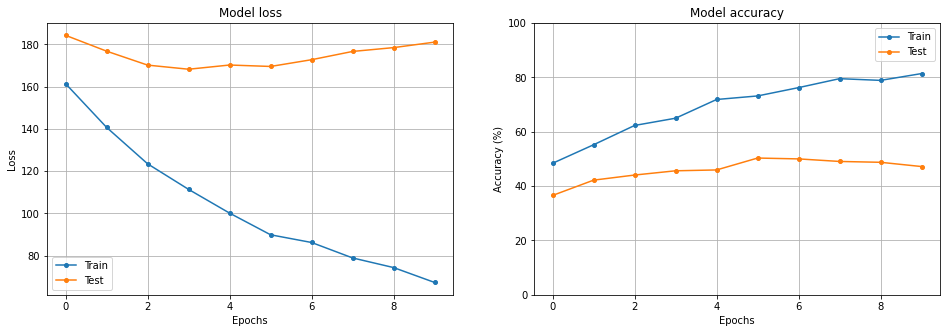

In [ ]:
plot_loss_accuracy(loss_cnn, acc_cnn)

In [ ]:
summary(model_RNN, (1, 10, 1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 128]              443,136
├─Linear: 1-3                            [1, 11]                   1,419
Total params: 446,603
Trainable params: 446,603
Non-trainable params: 0
Total mult-adds (M): 4.43
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 1.79
Estimated Total Size (MB): 1.92

In [ ]:
loss_rnn, acc_rnn = train(model_RNN, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[189.66,199.86] acc=[ 41.51, 37.50] 
E01 loss=[146.95,181.50] acc=[ 60.74, 40.94] 
E02 loss=[112.57,166.78] acc=[ 73.26, 43.44] 
E03 loss=[ 86.96,158.53] acc=[ 80.14, 45.00] 
E04 loss=[ 65.62,152.95] acc=[ 87.02, 51.56] 
E05 loss=[ 51.76,151.03] acc=[ 88.65, 50.00] 
E06 loss=[ 39.42,147.55] acc=[ 91.55, 51.56] 
E07 loss=[ 31.65,147.69] acc=[ 93.35, 51.25] 
E08 loss=[ 28.09,145.78] acc=[ 93.12, 53.44] 
E09 loss=[ 23.51,148.15] acc=[ 94.29, 53.44] 


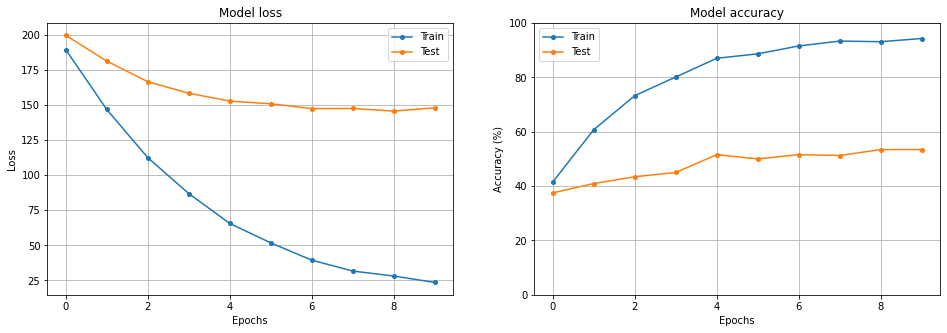

In [ ]:
plot_loss_accuracy(loss_rnn, acc_rnn)

In [ ]:
summary(model_RNN, (1, 10, 1024), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [1, 11]                   --
├─BatchNorm1d: 1-1                       [1, 1024, 10]             2,048
├─GRU: 1-2                               [1, 10, 128]              443,136
├─Linear: 1-3                            [1, 11]                   1,419
Total params: 446,603
Trainable params: 446,603
Non-trainable params: 0
Total mult-adds (M): 4.43
Input size (MB): 0.04
Forward/backward pass size (MB): 0.09
Params size (MB): 1.79
Estimated Total Size (MB): 1.92

In [ ]:
loss_rnn, acc_rnn = train(model_RNN, trn_dl, tst_dl,epochs=10,lr=1e-3,
                        opt='Adam',progress=True)

  0%|          | 0/10 [00:00<?, ?it/s]

E00 loss=[194.69,198.27] acc=[ 38.16, 38.12] 
E01 loss=[156.33,173.29] acc=[ 55.27, 48.12] 
E02 loss=[126.86,155.01] acc=[ 64.65, 50.94] 
E03 loss=[105.01,145.36] acc=[ 70.60, 53.44] 
E04 loss=[ 84.26,139.88] acc=[ 78.58, 54.38] 
E05 loss=[ 68.02,137.02] acc=[ 84.03, 57.81] 
E06 loss=[ 53.75,132.96] acc=[ 87.80, 59.69] 
E07 loss=[ 42.21,135.03] acc=[ 90.54, 56.25] 
E08 loss=[ 38.00,136.21] acc=[ 89.68, 58.75] 
E09 loss=[ 30.67,134.61] acc=[ 91.71, 58.44] 


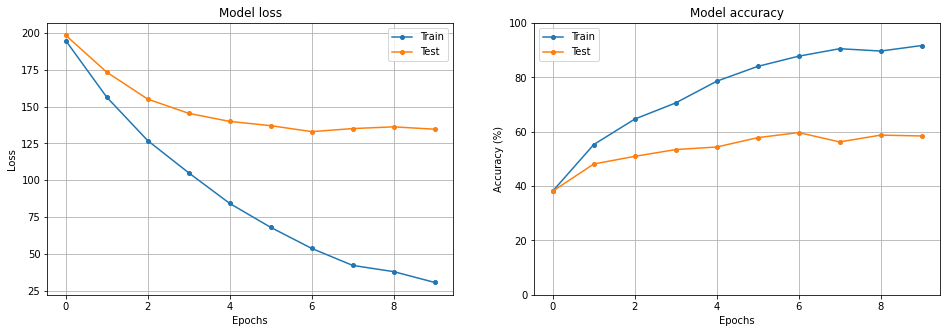

In [ ]:
plot_loss_accuracy(loss_rnn, acc_rnn)